In [1]:
import numpy as np
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense
from keras.datasets import cifar10
from matplotlib import pyplot as plt
from keras.backend import tf as ktf
from keras.backend import resize_images
import time, gc

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data and prepare it

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 42s 0us/step


(50000, 32, 32, 3)


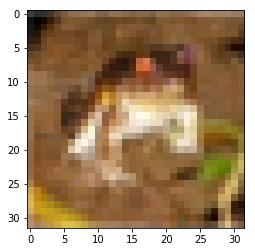

In [3]:
print(X_train.shape)
plt.imshow(X_train[0])

In [4]:
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]


### The VGG model takes a minimum input size of 48x48. We have to resize the training data

In [5]:
# Because I have a 4GB RAM computer with no GPU, I could only process part of the dataset, and in batches :)

X_train = X_train[:20000]
y_train = y_train[:20000]

X_test = X_test[:3000]
y_test = y_test[:3000]

def resize_training_set(training_set, resize_factor):
    start_time = time.time()

    new_training_set = None
    batch_size = 1000
    iterations_count = training_set.shape[0] // batch_size

    for i in range(0, iterations_count):
        print("Processing batch {}/{}.".format(i+1, iterations_count))
        
        from_index = i * batch_size
        to_index = (i + 1) * batch_size

        with ktf.Session() as sess:
            original_tensor = ktf.convert_to_tensor(training_set[from_index:to_index])
            resized_tensor = resize_images(original_tensor, resize_factor, resize_factor, "channels_last")
            
            resized_arr = resized_tensor.eval()
            float_arr = resized_arr.astype('float32')
            float_arr /= 255
            
            if i == 0:
                new_training_set = float_arr
            else:
                new_training_set = np.concatenate((new_training_set, float_arr))
            
            del original_tensor
            del resized_tensor
            del resized_arr
            del float_arr
            gc.collect()
    
    elapsed_time = time.time() - start_time
    print ("Resizing done in {}.".format(elapsed_time))
    gc.collect()
    return new_training_set

Original training set size: (20000, 32, 32, 3)
Original test set size: (3000, 32, 32, 3)


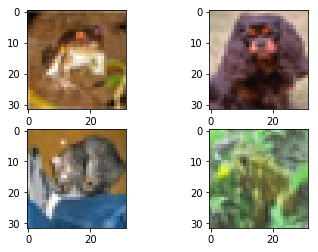

In [6]:
print("Original training set size: {}".format(X_train.shape))
print("Original test set size: {}".format(X_test.shape))

# Print some images before and after resizing to make sure that the data was not corrupted

fig=plt.figure()
fig.add_subplot(2, 2, 1)
plt.imshow(X_train[0])
fig.add_subplot(2, 2, 2)
plt.imshow(X_train[-1])

fig.add_subplot(2, 2, 3)
plt.imshow(X_test[0])
fig.add_subplot(2, 2, 4)
plt.imshow(X_test[-1])

In [7]:
# Resize the images by a factor of 2 to be 64x64px
X_train = resize_training_set(X_train, 2)
X_test = resize_training_set(X_test, 2)

Processing batch 1/20.
Processing batch 2/20.
Processing batch 3/20.
Processing batch 4/20.
Processing batch 5/20.
Processing batch 6/20.
Processing batch 7/20.
Processing batch 8/20.
Processing batch 9/20.
Processing batch 10/20.
Processing batch 11/20.
Processing batch 12/20.
Processing batch 13/20.
Processing batch 14/20.
Processing batch 15/20.
Processing batch 16/20.
Processing batch 17/20.
Processing batch 18/20.
Processing batch 19/20.
Processing batch 20/20.
Resizing done in 19.32540988922119.
Processing batch 1/3.
Processing batch 2/3.
Processing batch 3/3.
Resizing done in 1.7739522457122803.


New training set size: (20000, 64, 64, 3)
New test set size: (3000, 64, 64, 3)


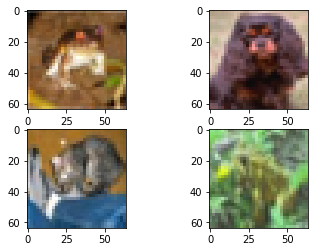

In [8]:
print("New training set size: {}".format(X_train.shape))
print("New test set size: {}".format(X_test.shape))

# Print some images before and after resizing to make sure that the data was not corrupted

fig=plt.figure()
fig.add_subplot(2, 2, 1)
plt.imshow(X_train[0])
fig.add_subplot(2, 2, 2)
plt.imshow(X_train[-1])

fig.add_subplot(2, 2, 3)
plt.imshow(X_test[0])
fig.add_subplot(2, 2, 4)
plt.imshow(X_test[-1])

In [9]:
# Convert class values to one-hot categorical values
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## Load VGG16 model and customize it

In [10]:
vgg16_model = VGG16(include_top=False, input_shape=(64, 64, 3))

58892288/58889256 [==============================] - 14s 0us/step


In [11]:
print(type(vgg16_model))
print(vgg16_model.summary())

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16

In [12]:
# No need to retrain the network
for layer in vgg16_model.layers:
    layer.trainable = False

# Add the fully-connected layers at the end
x = Flatten(name='flatten')(vgg16_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)

#Create your own model 
new_model = Model(inputs=vgg16_model.input, outputs=x)

print(new_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [13]:
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [14]:
new_model.fit(x=X_train, y=Y_train, validation_split=0.1, batch_size=32, epochs=10, verbose=1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 1373s 76ms/step - loss: 1.2828 - acc: 0.5719 - val_loss: 1.1148 - val_acc: 0.6250
Epoch 2/10
18000/18000 [==============================] - 1350s 75ms/step - loss: 0.9258 - acc: 0.6769 - val_loss: 1.0105 - val_acc: 0.6575
Epoch 3/10
18000/18000 [==============================] - 1355s 75ms/step - loss: 0.8078 - acc: 0.7164 - val_loss: 1.0482 - val_acc: 0.6530
Epoch 4/10
18000/18000 [==============================] - 1343s 75ms/step - loss: 0.7174 - acc: 0.7465 - val_loss: 1.0249 - val_acc: 0.6735
Epoch 5/10
18000/18000 [==============================] - 1345s 75ms/step - loss: 0.6341 - acc: 0.7748 - val_loss: 1.0744 - val_acc: 0.6650
Epoch 6/10
18000/18000 [==============================] - 1350s 75ms/step - loss: 0.5683 - acc: 0.7989 - val_loss: 1.0875 - val_acc: 0.6735
Epoch 7/10
18000/18000 [==============================] - 1351s 75ms/step - loss: 0.5005 - acc: 0.8226 - val_lo

In [15]:
score = new_model.evaluate(X_test, Y_test, verbose=1)
print("Accuracy: {0}".format(score[1]))

3000/3000 [==============================] - 171s 57ms/step
Accuracy: 0.6803333334922791


## Conclusion

This is a bad result after a long time of waiting and even restarting the humble compter a few times. I already had a better result last week with my own network: 74.53%

Was is overfitting? Did I need to use more data? Did I have to fine-tune the model because the images are much smaller that what it originally used for learning?

I can find out only when I have a faster environment to test my theories.